In [1]:
!pip install "dask[complete]"
!pip install pyarrow pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4


In [2]:
!pip install scikit-fuzzy
!pip install fuzzy-c-means

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.3 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.12.5
    Uninstalling typer-0.12.5:
      Successfully uninstalled typer-0.12.5


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import dask.dataframe as dd
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
import numpy as np
import skfuzzy as fuzz

from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
# Directory containing the data files
data_dir = '/content/drive/MyDrive/Data_hasking'

# Get a list of all parquet files and select those after the first 20 files (representing 20 days)
file_list = sorted(glob.glob(f"{data_dir}/*.parquet"))

# Select the next 40 files after the first 20 (representing the next 40 days)
next_40_days_files = file_list[20:20+40]

# Load all selected parquet files into a Dask DataFrame
ddf = dd.read_parquet(next_40_days_files)

# Compute the result if needed (e.g., to display the DataFrame)
df = ddf.compute()


In [6]:
# Load customer data
tb_customers = dd.read_parquet('/content/drive/MyDrive/TB_CUSTOMERS.parquet')
tb_customers_df = tb_customers.compute()

In [7]:
# Filter for individual customers
tb_customers_individual_df = tb_customers_df[tb_customers_df["CUSTOMER_TYPE"] == "Cá nhân"]
individual_customers = tb_customers_individual_df["CUST_CUSTNO"].unique().tolist()

In [8]:
# Filter transactions for individual customers
df_individual = df[df['CUST_CUSTNO'].isin(individual_customers)]

In [9]:
# Convert VALUEDATE to datetime
df_individual['VALUEDATE'] = pd.to_datetime(df_individual['VALUEDATE'], errors='coerce')

In [10]:
# Extract date only from VALUEDATE
df_individual['DATE_ONLY'] = df_individual['VALUEDATE'].dt.date

In [11]:
# Separate deposits (receipts) and withdrawals
df_deposits = df_individual[df_individual['AMOUNT'] > 0]
df_withdrawals = df_individual[df_individual['AMOUNT'] < 0]

In [12]:
# Aggregate amounts by customer and date
daily_deposits = df_deposits.groupby(['CUST_CUSTNO', 'DATE_ONLY'])['AMOUNT'].sum().reset_index(name='total_deposits')
daily_withdrawals = df_withdrawals.groupby(['CUST_CUSTNO', 'DATE_ONLY'])['AMOUNT'].sum().reset_index(name='total_withdrawals')

In [13]:
# Merge deposits and withdrawals
transactions = pd.merge(daily_deposits, daily_withdrawals, on=['CUST_CUSTNO', 'DATE_ONLY'], how='outer')

In [14]:
# Fill missing values with 0
transactions['total_deposits'].fillna(0, inplace=True)
transactions['total_withdrawals'].fillna(0, inplace=True)

In [15]:
# Log transform the total deposits and total withdrawals
transactions['log_total_deposits'] = np.log1p(transactions['total_deposits'])
transactions['log_total_withdrawals'] = np.log1p(transactions['total_withdrawals'].abs())

In [16]:
# Prepare the data for clustering
features = transactions[['log_total_deposits', 'log_total_withdrawals']].values

In [17]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

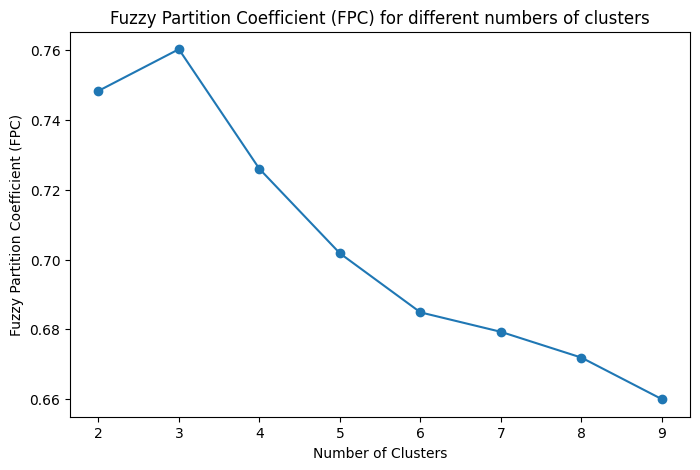

In [ ]:
# Define the range of clusters to evaluate
n_clusters_range = range(2, 10)
fpc_values = []

for n_clusters in n_clusters_range:
    # Apply Fuzzy C-Means clustering
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        features_scaled.T, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None)

    # Store the FPC value for this number of clusters
    fpc_values.append(fpc)

# Plot FPC values to visualize the optimal number of clusters
plt.figure(figsize=(8, 5))
plt.plot(n_clusters_range, fpc_values, marker='o')
plt.title('Fuzzy Partition Coefficient (FPC) for different numbers of clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Fuzzy Partition Coefficient (FPC)')
plt.show()

In [18]:
# Set the number of clusters
n_clusters = 3

In [19]:
# Apply Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    features_scaled.T, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None)

In [20]:
# Assign clusters to each transaction based on the highest membership
cluster_labels = np.argmax(u, axis=0)

In [21]:
# Add the cluster labels to the DataFrame
transactions['cluster'] = cluster_labels

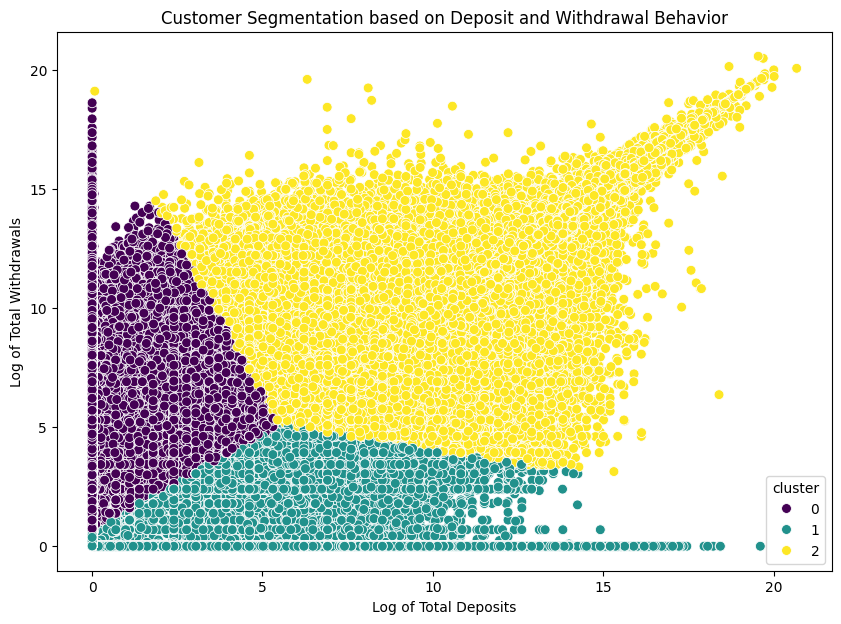

In [ ]:
# Visualize the distribution of transactions in each cluster
plt.figure(figsize=(10, 7))
sns.scatterplot(x='log_total_deposits', y='log_total_withdrawals', hue='cluster', data=transactions, palette='viridis', s=50)
plt.title('Customer Segmentation based on Deposit and Withdrawal Behavior')
plt.xlabel('Log of Total Deposits')
plt.ylabel('Log of Total Withdrawals')
plt.show()


In [22]:
# Count the number of transactions in each cluster
transactions['cluster'].value_counts()

,count
cluster,
1,2380812
2,2153774
0,1504080


In [23]:
# Calculate suspicion scores based on distance from the cluster centroid
suspicion_scores = np.min(d, axis=0)
transactions['suspicion_score'] = suspicion_scores

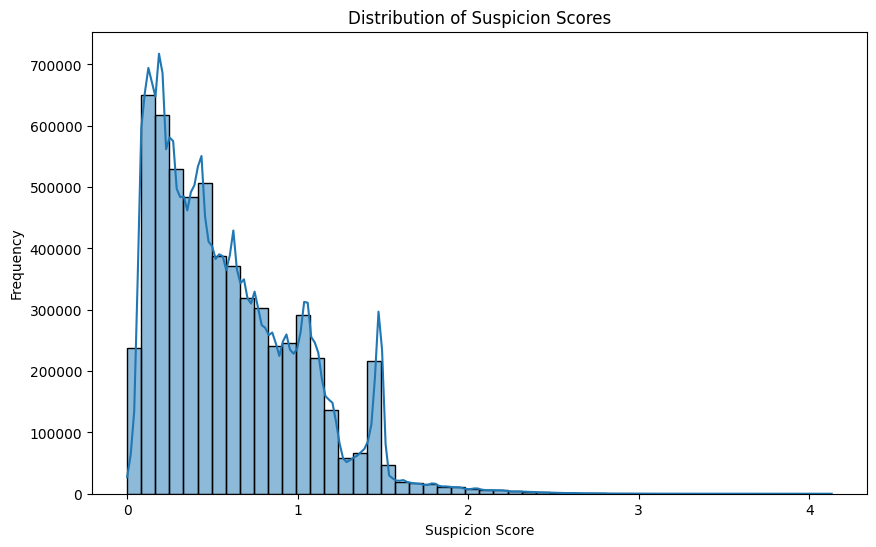

In [ ]:
# Plot the distribution of suspicion scores
plt.figure(figsize=(10, 6))
sns.histplot(transactions['suspicion_score'], bins=50, kde=True)
plt.title('Distribution of Suspicion Scores')
plt.xlabel('Suspicion Score')
plt.ylabel('Frequency')
plt.show()

In [24]:
# Calculate the 95th percentile for high suspicion scores
high_suspicion_percentile = np.percentile(transactions['suspicion_score'], 95)

# Add suspicion level to the DataFrame
transactions['suspicion_level'] = 'Low'  # Default to 'Low'
transactions.loc[transactions['suspicion_score'] > high_suspicion_percentile, 'suspicion_level'] = 'High'

print("High Suspicion Percentile:", high_suspicion_percentile)
# Count the number of transactions in each suspicion level
suspicion_level_counts = transactions['suspicion_level'].value_counts()
print(suspicion_level_counts)

High Suspicion Percentile: 1.4611264267277029
suspicion_level
Low     5739108
High     299558
Name: count, dtype: int64


In [25]:

# Classify transactions based on suspicion scores
def classify_transaction(score):
  if score > high_suspicion_percentile:
    return 'Fraudulent'

  else:
    return 'normal'

transactions['suspicion_level'] = transactions['suspicion_score'].apply(classify_transaction)

In [26]:
# Count the number of transactions in each suspicion level
transactions['suspicion_level'].value_counts()


,count
suspicion_level,
normal,5739108
Fraudulent,299558


In [27]:
# Group the transactions by cluster and calculate summary statistics
cluster_summary = transactions.groupby('cluster').agg({
    'log_total_deposits': ['mean', 'std'],
    'log_total_withdrawals': ['mean', 'std'],
    'suspicion_score': ['mean', 'std', 'min', 'max']
})

# Print the summary statistics
print(cluster_summary)

        log_total_deposits           log_total_withdrawals            \
                      mean       std                  mean       std   
cluster                                                                
0                 5.629470  3.151347              0.336475  1.101654   
1                 0.490357  1.372678              6.273932  1.863496   
2                 8.702049  2.213148              8.642359  2.227590   

        suspicion_score                                
                   mean       std       min       max  
cluster                                                
0              0.668983  0.470017  0.002776  3.153037  
1              0.487248  0.347892  0.000509  3.338393  
2              0.663778  0.441437  0.000371  4.131780  


In [28]:
# Apply Rule 15 conditions
rule_15_anomalies = transactions[
    (transactions['total_deposits'] >= 6000000) &
    (transactions['total_withdrawals'].abs() >= 0.95 * transactions['total_deposits'])
]
rule_15_anomalies

,CUST_CUSTNO,DATE_ONLY,total_deposits,total_withdrawals,log_total_deposits,log_total_withdrawals,cluster,suspicion_score,suspicion_level
296,0004abe134ca2b7af66656ecc3232a24a1167e71aa2bd9...,2023-09-23,8000493.15,-8000008.22,15.895014,15.894953,2,2.539515,Fraudulent
561,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-08-22,10469355.99,-10051700.46,16.163963,16.123252,2,2.627637,Fraudulent
567,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-08-29,7179280.10,-7513252.10,15.786710,15.832179,2,2.509942,Fraudulent
5280,0054e8a9bcf74283453465fc32c05e6d2bee5f8a07a888...,2023-09-26,7000000.00,-14000000.00,15.761421,16.454568,2,2.634707,Fraudulent
5293,0054e8ed0fc7c423be272f4ad89732eeb03d25911670c7...,2023-09-14,11084400.00,-14795680.55,16.221049,16.509846,2,2.715182,Fraudulent
...,...,...,...,...,...,...,...,...,...
3967152,fff1c57c3d4bfdda637d4c854ea3fb458cafd9b7dfdec2...,2023-09-20,15009000.00,-15004000.00,16.524161,16.523827,2,2.764806,Fraudulent
3967312,fff5865d6fd5d7a5893f904b1cb18479fa79ea3b09c4b3...,2023-09-14,12550243.88,-18550487.76,16.345251,16.736007,2,2.780664,Fraudulent
3967625,fff97e742a783a1f7e9a398a3b326f6354a970804f4781...,2023-08-23,6206100.00,-6206100.00,15.641043,15.641043,2,2.448560,Fraudulent
3967626,fff97e742a783a1f7e9a398a3b326f6354a970804f4781...,2023-09-12,6306100.00,-6282750.00,15.657028,15.653318,2,2.453536,Fraudulent


In [29]:

# Check if the specific account is flagged as an anomaly
specific_account = 'cc0b0d019b63002c450bc459d5b82713ca95f477e8ba82019ffa7651b0421620'
is_anomaly = specific_account in rule_15_anomalies['CUST_CUSTNO'].values

if is_anomaly:
  print(f"Account {specific_account} is flagged as a rule 15 anomaly.")
else:
  print(f"Account {specific_account} is not flagged as a rule 15 anomaly.")

# Check the suspicion level of the specific account
suspicion_level = transactions.loc[transactions['CUST_CUSTNO'] == specific_account, 'suspicion_level'].values[0]
print(f"Suspicion level of account {specific_account}: {suspicion_level}")


Account cc0b0d019b63002c450bc459d5b82713ca95f477e8ba82019ffa7651b0421620 is not flagged as a rule 15 anomaly.
Suspicion level of account cc0b0d019b63002c450bc459d5b82713ca95f477e8ba82019ffa7651b0421620: Fraudulent


In [ ]:
# Display the suspicion scores for the specific account
specific_account_scores = transactions.loc[transactions['CUST_CUSTNO'] == 'cc0b0d019b63002c450bc459d5b82713ca95f477e8ba82019ffa7651b0421620', 'suspicion_score']
print(specific_account_scores)


3167116    1.478276
3167117    1.846287
Name: suspicion_score, dtype: float64


In [31]:

specific_customer_transactions = df_individual[
    df_individual['CUST_CUSTNO'] == 'cc0b0d019b63002c450bc459d5b82713ca95f477e8ba82019ffa7651b0421620'
]
specific_customer_transactions


,CUST_CUSTNO,ACC_BUSINESSTYPE,ACC_ACCNO,ACC_BUSINESSNO,ACC_CURRENCYISO,BUSINESSNO_TRANS,FK_CURRENCY,AMOUNT,AMOUNTORIG,BRANCH_OFFICE,...,TR_FLAG_01,ANALYTICAL_TRANS_CODE,TR_SP_01,TR_SP_02,TR_SP_03,TR_SP_04,TR_SP_05,TR_SP_10,VALUEDATE,DATE_ONLY
282996,cc0b0d019b63002c450bc459d5b82713ca95f477e8ba82...,CASA,c5056de83d889e0ad13c6ae151a11841a6c5ae66544fc3...,0553d33b8bbc8e3a944ff438a51a17cfb38fd0241667af...,VND,2023083119953061,VND,0.06,0.06,110200,...,N,2|2,cdf1f873fa6bb34ce8ceaee5554bd5ef7413b2d67ea795...,BRC,CN HA NOI,AA,<NA>,NaN,2023-08-31,2023-08-31
697031,cc0b0d019b63002c450bc459d5b82713ca95f477e8ba82...,TIDE,9b7e74bc2eee279ccf22e74f856382ff8f42a2447e7754...,0553d33b8bbc8e3a944ff438a51a17cfb38fd0241667af...,VND,2023091127562363,VND,1300000.00,1300000.00,110205,...,N,2|11,0900938aa8aa41d0b82438bb7481fe142f0072273c4530...,BRC,PGD HANG COT/CN HA NOI,TD,<NA>,NaN,2023-09-11,2023-09-11


In [32]:

# Find the transaction with the maximum suspicion score
max_score_transaction = transactions.loc[transactions['suspicion_score'] == transactions['suspicion_score'].max()]
# Check if the transaction with the maximum suspicion score is flagged as a rule 15 anomaly
max_score_custno = max_score_transaction['CUST_CUSTNO'].values[0]
is_max_score_anomaly = max_score_custno in rule_15_anomalies['CUST_CUSTNO'].values

if is_max_score_anomaly:
  print(f"The transaction with the maximum suspicion score for customer {max_score_custno} is flagged as a rule 15 anomaly.")
else:
  print(f"The transaction with the maximum suspicion score for customer {max_score_custno} is not flagged as a rule 15 anomaly.")

max_score_transaction

The transaction with the maximum suspicion score for customer 06e22a6a7c4dfbc660330a2fffeff24368c12a9d42fe7d86b5391224f6b4b4a8 is flagged as a rule 15 anomaly.


,CUST_CUSTNO,DATE_ONLY,total_deposits,total_withdrawals,log_total_deposits,log_total_withdrawals,cluster,suspicion_score,suspicion_level
104774,06e22a6a7c4dfbc660330a2fffeff24368c12a9d42fe7d...,2023-08-21,954992660.0,-522199200.0,20.677214,20.07356,2,4.13178,Fraudulent


In [40]:
# Find the account with the maximum deposit
max_deposit_account = transactions.loc[transactions['total_deposits'] == transactions['total_deposits'].max()]
print("Account with maximum deposit:")
max_deposit_account

Account with maximum deposit:


,CUST_CUSTNO,DATE_ONLY,total_deposits,total_withdrawals,log_total_deposits,log_total_withdrawals,cluster,suspicion_score,suspicion_level
104774,06e22a6a7c4dfbc660330a2fffeff24368c12a9d42fe7d...,2023-08-21,954992660.0,-522199200.0,20.677214,20.07356,2,4.13178,Fraudulent


In [41]:


# Find the account with the maximum withdrawal
max_withdrawal_account = transactions.loc[transactions['total_withdrawals'] == transactions['total_withdrawals'].min()]
print("\nAccount with maximum withdrawal:")
max_withdrawal_account



Account with maximum withdrawal:


,CUST_CUSTNO,DATE_ONLY,total_deposits,total_withdrawals,log_total_deposits,log_total_withdrawals,cluster,suspicion_score,suspicion_level
2076446,860fc4310fbc0e7789500b2b185b1ddb3dcbdc8bc774de...,2023-08-25,3.087480e+08,-8.670911e+08,19.548036,20.580655,2,4.060829,Fraudulent
